# Modelling the data

In [1]:
# Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
import seaborn as sns

df = pd.read_csv('../../data/df_main.csv')

In [2]:
df.loc[(df['year'] == 2004) & (df['from_code2'] == 'united kingdom')].shape

(0, 28)

## XGBoost to predict if score given

First step in the hurdle model.

Example: https://www.kaggle.com/code/sriharinitumu/light-gbm-with-hurdle-modelling


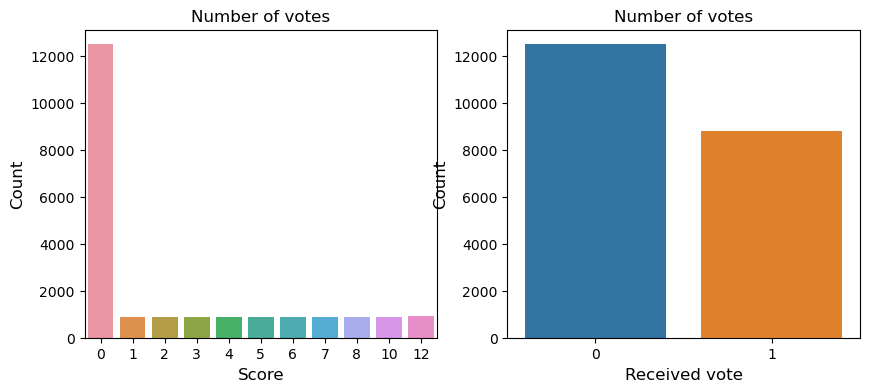

In [3]:
df['received_vote'] = df['points'].apply(lambda x: 1 if x > 0 else 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Bar chart for vote occurrences
sns.countplot(x="points", data=df, ax=ax1)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Score', fontsize=12)
ax1.set_title('Number of votes', fontsize=12)

sns.countplot(x="received_vote", data=df, ax=ax2)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Received vote', fontsize=12)
ax2.set_title('Number of votes', fontsize=12)

plt.show()

As you can see we have a lot of zeroes....this probably makes this problem appropriate for a hurdle model. Where we first decide if a score is given, and then if it is, we predict the score.

In [4]:
df.columns

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'migration_v2p', 'population_p', 'prop_emigrants_v2p', 'migration_p2v',
       'population_v', 'prop_emigrants_p2v', 'migration_pop_year',
       'comps_without_win', 'has_border', 'received_vote'],
      dtype='object')

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/1723737896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/1723737896.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['prop_emigrants_v2p'] = df_xgboost['prop_emigrants_v2p'].apply(lambda x: np.log10(x+4e-8))
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/1723737896.py:18: SettingWit

<AxesSubplot:>

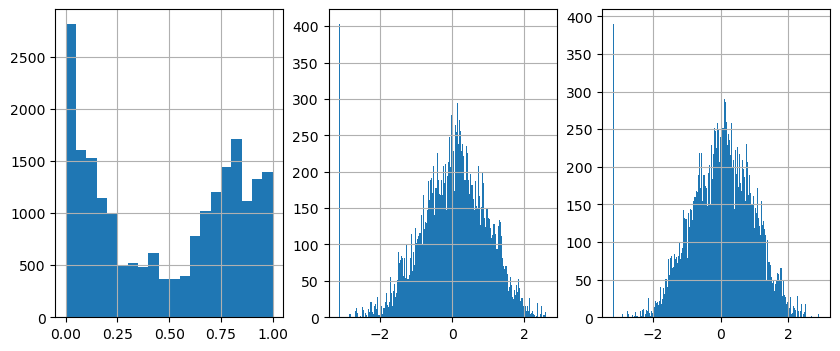

In [5]:
# scale some of the features

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


df_xgboost = df[['year', 'from_code2', 'points', 'to_code2',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'has_border',
       'comps_without_win', 'received_vote']]

df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)

# log10 scale the prop_emigrants column
df_xgboost['prop_emigrants_v2p'] = df_xgboost['prop_emigrants_v2p'].apply(lambda x: np.log10(x+4e-8))
df_xgboost['prop_emigrants_p2v'] = df_xgboost['prop_emigrants_p2v'].apply(lambda x: np.log10(x+4e-8))


# apply the standard scaler to prop_emigrants and comps_without_win
scaler = StandardScaler()
df_xgboost[['prop_emigrants_v2p']] = scaler.fit_transform(df_xgboost[['prop_emigrants_v2p']])
df_xgboost[['prop_emigrants_p2v']] = scaler.fit_transform(df_xgboost[['prop_emigrants_p2v']])

scaler = MinMaxScaler()
df_xgboost[['comps_without_win']] = scaler.fit_transform(df_xgboost[['comps_without_win']])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# histogram of the log scaled prop_emigrants column
df_xgboost['comps_without_win'].hist(bins=20, ax=ax1)
df_xgboost['prop_emigrants_v2p'].hist(bins=200, ax=ax2)
df_xgboost['prop_emigrants_p2v'].hist(bins=200, ax=ax3)

In [6]:

from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def basic_xgboost(df_input, seed, test_size, predictor_column='received_vote'):
    X = df_input[['from_code2', 'to_code2', 'points',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v','has_border',
       'comps_without_win', "received_vote"]]



    Y = df_input[predictor_column]


    # one hot encode the gender, from country and code
    for j in ['gender', 'from_code2', 'to_code2']:
        j_text = '_voting' if j == 'from_code2' else ''
        for i in X[j].unique():
            output_binary = X[j].apply(lambda x: 1 if x == i else 0)
            X[i+j_text] = output_binary

        X = X[X.columns.drop(j)]

    # convert Y to int
    Y = Y.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed, stratify=X['points'])

    test_all = X_test

    # remove 'Votes' and 'received_vote' columns from X_train
    X_train = X_train[X_train.columns.drop('points')]
    X_train = X_train[X_train.columns.drop('received_vote')]
    X_test = X_test[X_test.columns.drop('points')]
    X_test = X_test[X_test.columns.drop('received_vote')]

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    return model, X_test, y_test, test_all

def model_predictions(model, X_test, y_test):
    Xt = X_test.copy()
    y_pred = model.predict(Xt)
    predictions = [round(value) for value in y_pred]

    Xt['predictions'] = predictions
    Xt['actual'] = y_test

    return Xt

def model_evalutation(df_pred):
    # evaluate predictions
    accuracy = accuracy_score(df_pred['actual'], df_pred['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # print a confusion matrix heatmap

    cm = confusion_matrix(df_pred['actual'], df_pred['predictions'])
    sns.heatmap(cm, annot=True, fmt="d")

    # add title and axis labels
    plt.title('Confusion matrix' + "(Accuracy={:.3f})".format(accuracy))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 75.19%


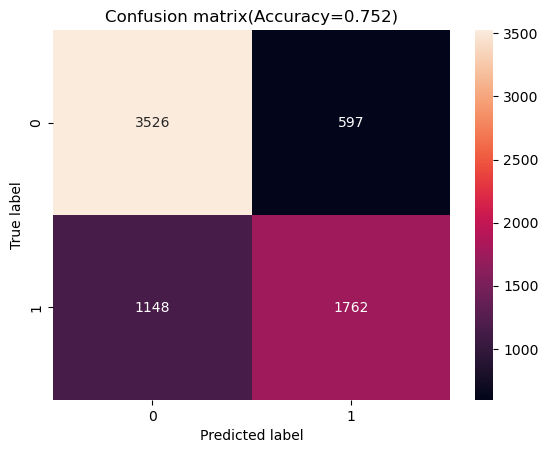

In [7]:
model_basic, X_test, y_test, test_all = basic_xgboost(df_xgboost, seed=7, test_size=0.33)
predictions = model_predictions(model_basic, X_test, y_test)
model_evalutation(predictions)

In [9]:
for i in  test_all.columns:
    print(i)

points
Contains_English
Contains_NonEnglish
Contains_Multiple_Languages
Number_of_Languages
Contains_Own_Language
prop_emigrants_v2p
prop_emigrants_p2v
has_border
comps_without_win
received_vote
female
male
group
BE_voting
HR_voting
CY_voting
EE_voting
MK_voting
FI_voting
FR_voting
DE_voting
GR_voting
HU_voting
IE_voting
IL_voting
MT_voting
NO_voting
PL_voting
PT_voting
RO_voting
SK_voting
SI_voting
ES_voting
SE_voting
CH_voting
NL_voting
TR_voting
GB_voting
AT_voting
BA_voting
DK_voting
IS_voting
LT_voting
LV_voting
RU_voting
UA_voting
AL_voting
AD_voting
BY_voting
MC_voting
YU_voting
BG_voting
MD_voting
AM_voting
CZ_voting
GE_voting
ME_voting
RS_voting
AZ_voting
SM_voting
IT_voting
AU_voting
HR
CY
EE
MK
FI
FR
DE
GR
HU
IE
IL
MT
NO
PL
PT
RO
SK
SI
ES
SE
CH
NL
TR
GB
BE
BA
DK
IS
LT
AT
LV
RU
UA
YU
AL
MD
AM
BY
BG
GE
RS
AZ
IT
ME
SM
AU
CZ


<AxesSubplot:>

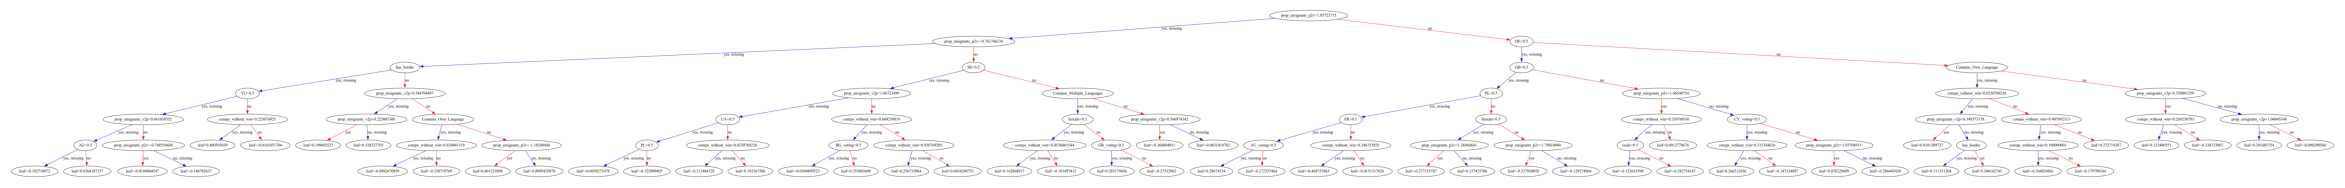

In [10]:
import matplotlib
import xgboost as xgb

graph = xgb.to_graphviz(model_basic, num_trees=1, rankdir='LR')

fig, ax = plt.subplots(figsize=(30, 50))
xgb.plot_tree(model_basic, num_trees=1, ax=ax)

## Ranking Scores

So of those, lets subset to only those with a score

In [11]:
test_all.head()

,points,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,...,BY,BG,GE,RS,AZ,IT,ME,SM,AU,CZ
10585,0,True,True,True,2,True,-0.399532,-0.866897,False,0.076923,...,0,0,0,0,0,0,0,0,0,0
1958,0,False,True,False,1,True,-0.644757,-0.049910,False,0.692308,...,0,0,0,0,0,0,0,0,0,0
9579,10,True,False,False,1,False,-0.571965,0.229081,False,0.353846,...,0,0,0,0,0,0,0,0,0,0
2178,8,True,False,False,1,True,-0.017305,-1.118413,False,0.707692,...,0,0,0,0,0,0,0,0,0,0
1776,0,False,True,False,1,True,1.287103,-0.190789,False,0.030769,...,0,0,0,0,0,0,0,0,0,0


In [12]:
import xgboost as xgb
from scipy.stats import rankdata
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import spearmanr
import numpy as np


def xgboost_rank_model(df_input, test_size=0.33, seed=7):

    df2 = df_input[['year', 'from_code2', 'to_code2', 'points',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v','has_border',
       'comps_without_win']]

    #df2 = df2.loc[df2['Votes'] > 0]

    #df2['has_border'] = df2['has_border'].fillna(0)
    df2 = df2.rename(columns={"points": 'rank'})
    #df2 = df2.rename(columns={"From country": 'id'})

    df2['rank'] = df2['rank'].astype(int) - 1

    df2['id'] = df2['from_code2'].astype(str) + df2['year'].astype(str)

    # one hot encode the gender, from country and code
    for j in ['gender', 'to_code2', 'from_code2']:
        j_text = "_voting" if j == 'from_code2' else ''
        for i in df2[j].unique():
            df2[i+j_text] = df2[j].apply(lambda x: 1 if x == i else 0)

        df2 = df2[df2.columns.drop(j)]

    #df2= df2[df2.columns.drop('From country')]
    df2= df2[df2.columns.drop('year')]

    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state = seed).split(df2, groups=df2['id'])

    X_train_inds, X_test_inds = next(gss)

    train_data= df2.iloc[X_train_inds]
    X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank'])]
    y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

    groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

    test_data= df2.iloc[X_test_inds]
    test_data = test_data[X_train.columns.tolist() + ['rank', 'id']]

    #We need to keep the id for later predictions
    # X_test = test_data.loc[:, ~test_data.columns.isin(['rank'])]
    # y_test = test_data.loc[:, test_data.columns.isin(['rank'])]

    model = xgb.XGBRanker(  
        tree_method='hist',
        booster='gbtree',
        objective='rank:pairwise',
        random_state=7, 
        learning_rate=0.1,
        colsample_bytree=0.9, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=110, 
        subsample=0.75 
    )

    model.fit(X_train, y_train, group=groups, verbose=True)

    return model, test_data, train_data

 

def ranked_model_predictions(model, test_set):
    test = test_set.copy()
    
    test['prediction_rel'] = np.nan
    test['predictions'] = np.nan

    for i in test['id'].unique():
        sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

        preds = model.predict(sub_test)

        # get the order of the predictions 
        res = rankdata(preds, method='ordinal')
        test.loc[test['id'] == i, 'prediction_rel'] = res

        # create a score for top 10 predictions getting 1:10 and others 0
        top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values


        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
        
        # if not zero subtract min(top10) 
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

        # if 10 set to 12
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

    test['actual'] = test['rank'] + 1


    accuracy = accuracy_score(test['actual'], test['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    return test

In [13]:
model_ranked, test_data, train_data = xgboost_rank_model(df_xgboost.loc[df_xgboost['points'] > 0], seed=7, test_size=0.33)
out = ranked_model_predictions(model_ranked, test_data)

Accuracy: 15.22%


In [15]:
out['predictions'].value_counts()

5.0     288
12.0    288
1.0     288
8.0     288
6.0     288
7.0     288
4.0     288
2.0     288
10.0    288
3.0     288
0.0      24
Name: predictions, dtype: int64

### Plots

In [16]:
def violins(pred):
    prediction_df = pred.copy()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7)) 

    if(max(prediction_df['actual']) < 12):        
        prediction_df['predictions'] = prediction_df['predictions'] + 1
        prediction_df['actual'] = prediction_df['actual'] + 1
        prediction_df['predictions'] = prediction_df['predictions'].apply(lambda x: 12 if x == 10 else x)
        prediction_df['predictions'] = prediction_df['predictions'].apply(lambda x: 10 if x == 9 else x)
        prediction_df['actual'] = prediction_df['actual'].apply(lambda x: 12 if x == 10 else x)
        prediction_df['actual'] = prediction_df['actual'].apply(lambda x: 10 if x == 9 else x)

    # violin plot of predictions for each rank
    sns.violinplot(x="actual", y="predictions", data=prediction_df, order=range(0, 13), ax=ax1)
    sns.violinplot(y="actual", x="predictions", data=prediction_df, order=range(0, 13), ax=ax2)

    # add a best fit line - scale is wrong because numeric on top of categorical
    sns.regplot(x="actual", y="predictions", data=prediction_df, scatter=False, color='black', ax=ax1)
    sns.regplot(y="actual", x="predictions", data=prediction_df, scatter=False, color='black', ax=ax2)


    # spearman correlation
    corr, _ = spearmanr(prediction_df['actual'], prediction_df['predictions'])

    fig.suptitle('Predicted Score vs Actual Score (r = ' + str(round(corr, 4)) + ')', fontsize=15)

    # set x label
    ax1.set_xlabel('Actual Score')
    ax1.set_ylabel('Predicted Score')
    ax2.set_ylabel('Actual Score')
    ax2.set_xlabel('Predicted Score')

def cm_heatmap (prediction_df, title='Confusion matrix', ax=None):
    cm = confusion_matrix(prediction_df['actual'], prediction_df['predictions'])

    plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=100)

    if(len(cm[[0]][0]) == 11) : 
    # change the tick labels
        plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    else: 
        plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

    plot.set_title(title)
    plot.set_ylabel('Actual Score')
    plot.set_xlabel('Predicted Score')

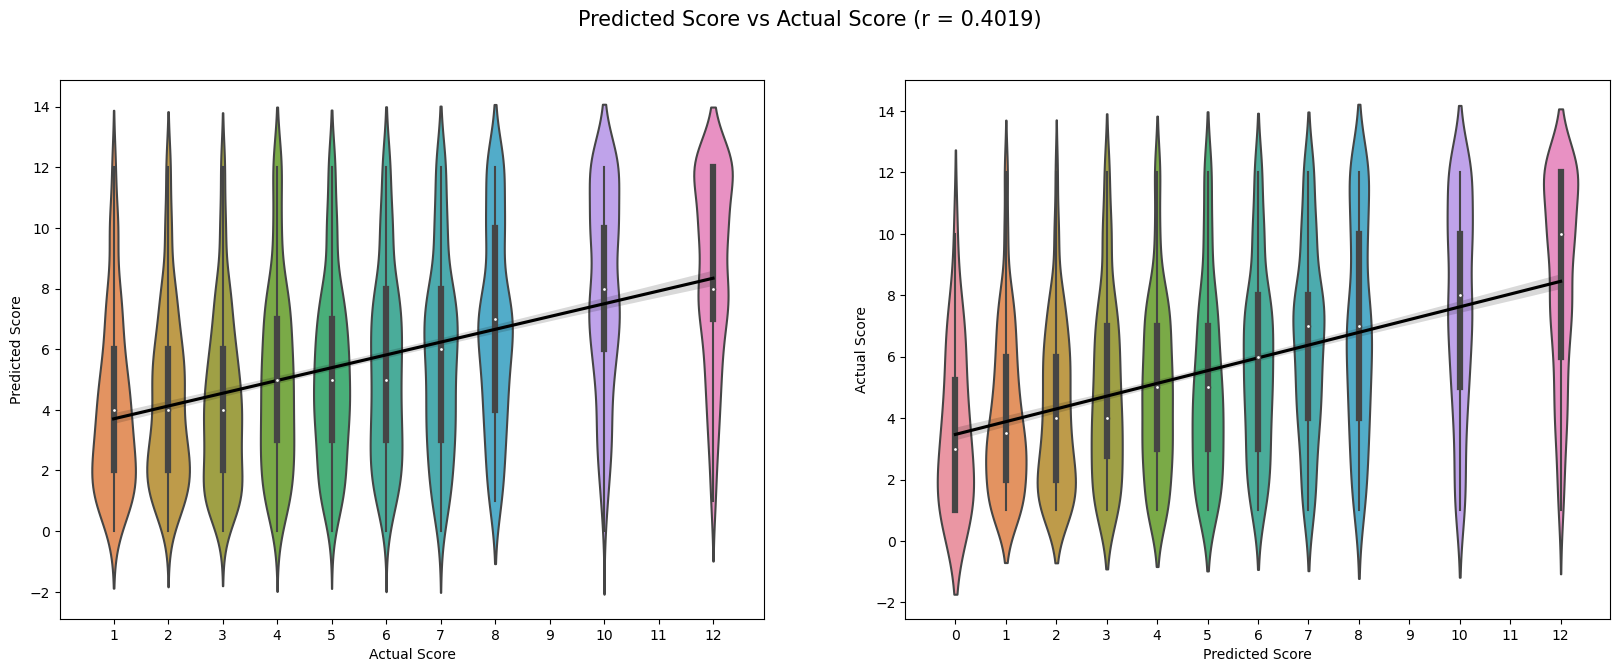

In [17]:
violins(out)

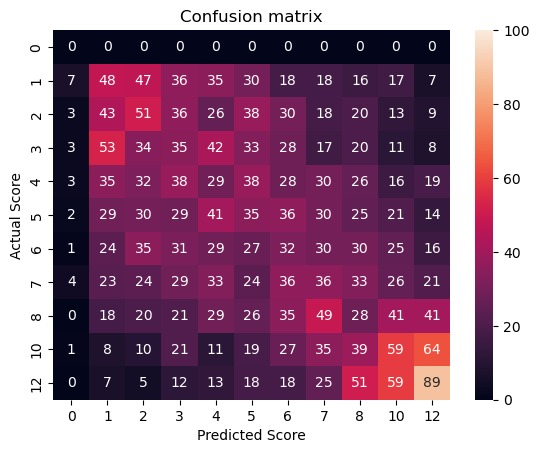

In [18]:
cm_heatmap(out)

See [here](https://discuss.xgboost.ai/t/evaluating-xgboost-ranking/959/2) for description of prediction scores

The 0 predictions are coming up when we have more that 10 non-zeroes (due to draws). So this actually works quite well I think.

### Quickly see how this compares to a non pairwise rank model


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/1277101257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes["points"] - 1
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/1277101257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/1277101257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

Accuracy: 13.57%


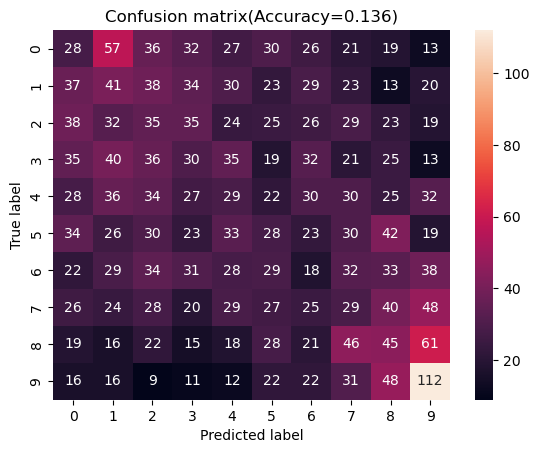

In [19]:
df_votes = df_xgboost.loc[df_xgboost['points'] > 0]

df_votes['Votes2'] = df_votes["points"] - 1
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 9 if x == 11 else x)

model, X_test, y_test, t2 = basic_xgboost(df_votes, seed=7, test_size=0.33, predictor_column='Votes2')
predictions = model_predictions(model, X_test, y_test)
model_evalutation(predictions)

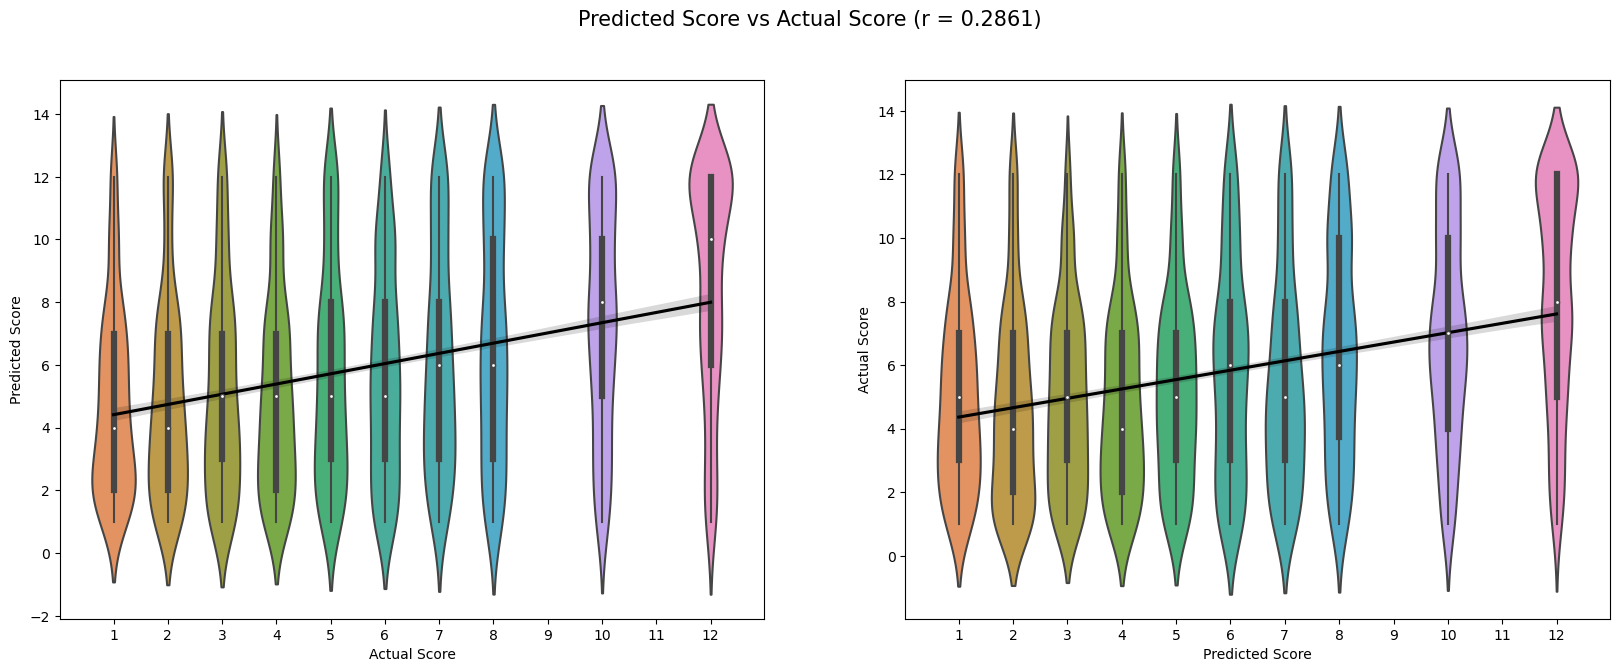

In [20]:
violins(predictions)

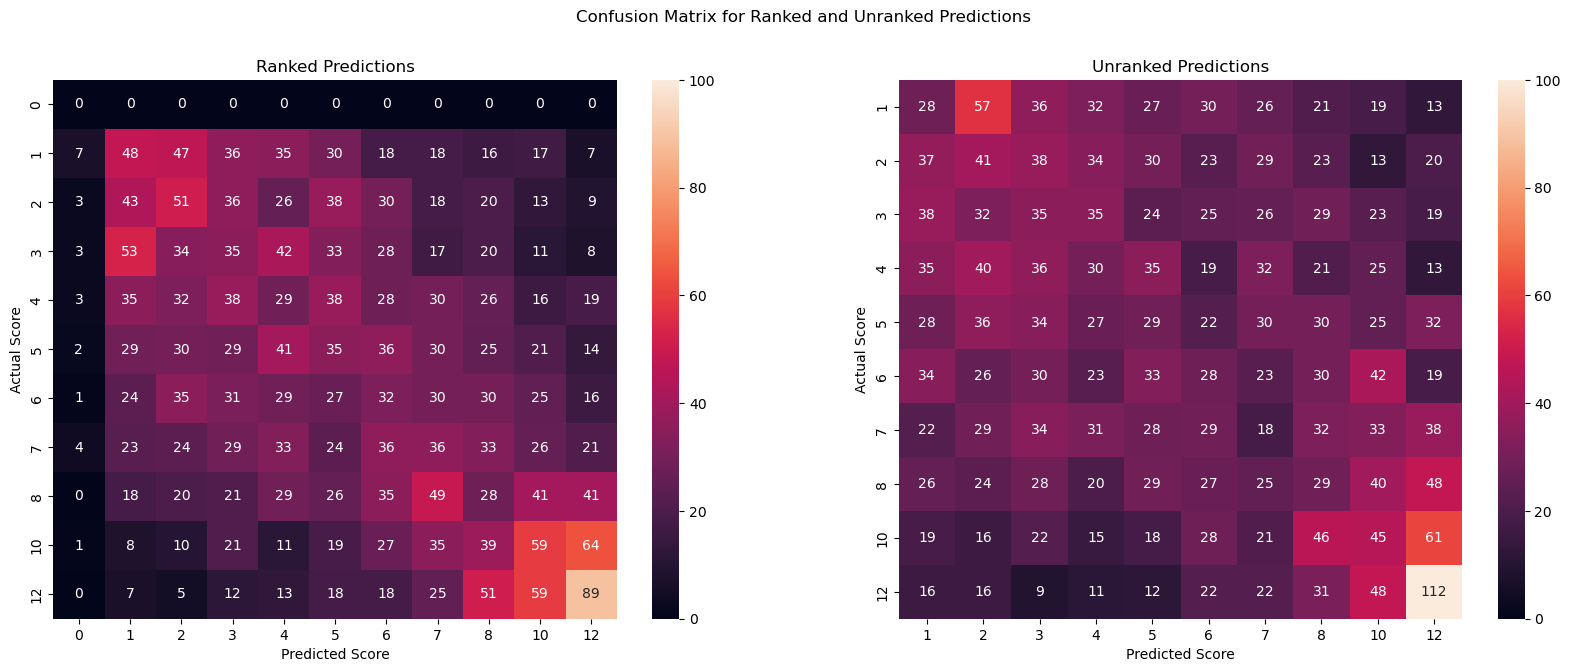

In [21]:
# ranked and unranked plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Confusion Matrix for Ranked and Unranked Predictions')

# ranked plot
cm_heatmap(out, title='Ranked Predictions', ax=ax1)
cm_heatmap(predictions, title='Unranked Predictions', ax=ax2)

# Combine the hurdles

In [22]:
df_xgboost.head()

,year,from_code2,points,to_code2,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,gender,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,received_vote
0,1998,BE,5,HR,False,True,False,1,True,female,-0.459294,-1.228039,False,0.646154,1
1,1998,BE,2,CY,False,True,False,1,True,male,-0.123958,-1.202616,False,0.646154,1
2,1998,BE,0,EE,False,True,False,1,True,male,-3.141613,-1.316419,False,0.646154,0
3,1998,BE,0,MK,False,True,False,1,True,male,NaN,-1.034414,False,0.646154,0
4,1998,BE,0,FI,False,True,False,1,True,group,-0.632590,-0.063750,False,0.646154,0


In [23]:
df_xgboost['id'] = df_xgboost['from_code2'] + df_xgboost['year'].astype(str)

df_xgboost['rank'] = df_xgboost['points']

df_xgboost['rank'] = df_xgboost['rank'].apply(lambda x: 9 if x == 10 else x)
df_xgboost['rank'] = df_xgboost['rank'].apply(lambda x: 10 if x == 12 else x)

#df_xgboost['rank'].value_counts()
df_xgboost['rank'] = df_xgboost['rank'].astype(int)

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/3525465728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['id'] = df_xgboost['from_code2'] + df_xgboost['year'].astype(str)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/3525465728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['rank'] = df_xgboost['points']
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_7780/3525465728.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

In [24]:
df_hurdle = df_xgboost.copy()

#df_hurdle['has_border'] = df_hurdle['has_border'].fillna(0)

df_hurdle.head()


,year,from_code2,points,to_code2,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,gender,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,received_vote,id,rank
0,1998,BE,5,HR,False,True,False,1,True,female,-0.459294,-1.228039,False,0.646154,1,BE1998,5
1,1998,BE,2,CY,False,True,False,1,True,male,-0.123958,-1.202616,False,0.646154,1,BE1998,2
2,1998,BE,0,EE,False,True,False,1,True,male,-3.141613,-1.316419,False,0.646154,0,BE1998,0
3,1998,BE,0,MK,False,True,False,1,True,male,NaN,-1.034414,False,0.646154,0,BE1998,0
4,1998,BE,0,FI,False,True,False,1,True,group,-0.632590,-0.063750,False,0.646154,0,BE1998,0


In [25]:
# one hot encode the gender, from country and code
for j in ['gender', 'to_code2', 'from_code2']:
    j_text = "_voting" if j == 'from_code2' else ''
    for i in df_hurdle[j].unique():
        df_hurdle[i+j_text] = df_hurdle[j].apply(lambda x: 1 if x == i else 0)

    df_hurdle = df_hurdle[df_hurdle.columns.drop(j)]

#df2= df2[df2.columns.drop('From country')]
df_hurdle= df_hurdle[df_hurdle.columns.drop('year')]

df_hurdle.head()

,points,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,...,MD_voting,AM_voting,CZ_voting,GE_voting,ME_voting,RS_voting,AZ_voting,SM_voting,IT_voting,AU_voting
0,5,False,True,False,1,True,-0.459294,-1.228039,False,0.646154,...,0,0,0,0,0,0,0,0,0,0
1,2,False,True,False,1,True,-0.123958,-1.202616,False,0.646154,...,0,0,0,0,0,0,0,0,0,0
2,0,False,True,False,1,True,-3.141613,-1.316419,False,0.646154,...,0,0,0,0,0,0,0,0,0,0
3,0,False,True,False,1,True,NaN,-1.034414,False,0.646154,...,0,0,0,0,0,0,0,0,0,0
4,0,False,True,False,1,True,-0.632590,-0.063750,False,0.646154,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

# select a random sample of 33% of the unique values of df_hurdle['id']
test_groups = np.random.choice(df_hurdle['id'].unique(), size=int(len(df_hurdle['id'].unique())*0.33), replace=False)
train_groups = np.setdiff1d(df_hurdle['id'].unique(), test_groups)

train_data = df_hurdle.loc[df_hurdle['id'].isin(train_groups)]
test_data = df_hurdle.loc[df_hurdle['id'].isin(test_groups)]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_train = train_data.loc[:, train_data.columns.isin(['received_vote'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_test = test_data.loc[:, test_data.columns.isin(['received_vote'])]


In [27]:
model = xgb.XGBClassifier()
hurdle1_model = model.fit(X_train, y_train)

In [28]:
hurdle1_df = model_predictions(hurdle1_model, X_test,  y_test)

# merge test_data and hurdle1_df
cols = [i for i in test_data.columns if i not in hurdle1_df.columns]
hurdle1_df = pd.merge(hurdle1_df, test_data[cols], left_index=True, right_index=True)

hurdle1_df.head()

,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,female,...,AZ_voting,SM_voting,IT_voting,AU_voting,predictions,actual,points,received_vote,id,rank
120,False,True,False,1,True,0.011488,-0.704802,False,0.169231,1,...,0,0,0,0,1,0,0,0,FI1998,0
121,False,True,False,1,True,-1.509230,-1.091633,False,0.646154,1,...,0,0,0,0,1,1,3,1,FI1998,3
122,False,True,False,1,True,0.119736,-1.084409,False,0.646154,0,...,0,0,0,0,0,0,0,0,FI1998,0
123,False,True,False,1,True,0.597183,0.485293,False,0.646154,0,...,0,0,0,0,1,1,12,1,FI1998,10
124,False,True,False,1,True,NaN,-3.202036,False,0.646154,0,...,0,0,0,0,0,0,0,0,FI1998,0


Accuracy: 75.00%


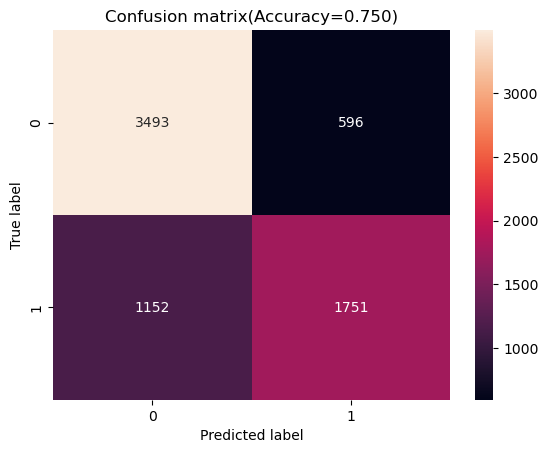

In [29]:
model_evalutation(hurdle1_df)

In [30]:
df2 = hurdle1_df.loc[hurdle1_df['predictions'] > 0]

# remove predictions, actual and received_vote columns
df2 = df2[df2.columns.drop(['predictions', 'actual', "points", 'received_vote'])]

print(df2['rank'].value_counts())

#df2 = df2.rename(columns={"Votes": 'rank'})
#df2 = df2.rename(columns={"From country": 'id'})

#df2['rank'] = df2['rank'].astype(int) - 1


# select a random sample of 33% of the unique values of df_hurdle['id']
test_groups = np.random.choice(df2['id'].unique(), size=int(len(df2['id'].unique())*0.33), replace=False)
train_groups = np.setdiff1d(df2['id'].unique(), test_groups)

train_data = df2.loc[df2['id'].isin(train_groups)]
test_data = df2.loc[df2['id'].isin(test_groups)]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['id','rank', 'points', 'received_vote'])]
y_test = test_data.loc[:, test_data.columns.isin(['rank'])]

print(test_data['id'].value_counts())
print(train_data['id'].value_counts())

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

model_ranked = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=7, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
)

model_ranked.fit(X_train, y_train, group=groups, verbose=True)

0     596
10    262
9     244
8     224
7     192
6     183
5     164
4     140
3     130
1     114
2      98
Name: rank, dtype: int64
LT2014    12
CH1998    12
GB2012    12
RO2019    12
GR2004    11
          ..
SI2009     5
FI2011     5
CZ2009     5
FI2009     4
TR2003     4
Name: id, Length: 94, dtype: int64
RO2021    14
CH2004    13
TR1998    12
AT2004    12
ES2018    12
          ..
MT2007     5
NL2014     5
FI2006     4
BG2016     4
IS2010     3
Name: id, Length: 193, dtype: int64


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=110, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

In [31]:
from scipy.stats import rankdata
from sklearn.metrics import accuracy_score

test = test_data.copy()

test['prediction_rel'] = np.nan
test['predictions'] = np.nan

for i in test['id'].unique():
    sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

    preds = model.predict(sub_test)

    # get the order of the predictions 
    res = rankdata(preds, method='ordinal')
    test.loc[test['id'] == i, 'prediction_rel'] = res

    # create a score for top 10 predictions getting 1:10 and others 0
    top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values


    test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
    
    # if not zero subtract min(top10) 
    test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

    # if 10 set to 12
    #test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
    #test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

test['actual'] = test['rank'] 


accuracy = accuracy_score(test['actual'], test['predictions'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

predictions2 = test

Accuracy: 8.19%


In [32]:
predictions2['actual'].value_counts()

0     194
10     86
9      77
7      67
8      67
6      64
5      53
4      47
3      46
2      35
1      33
Name: actual, dtype: int64

In [33]:
for i in hurdle1_df.columns:
    print(i)

Contains_English
Contains_NonEnglish
Contains_Multiple_Languages
Number_of_Languages
Contains_Own_Language
prop_emigrants_v2p
prop_emigrants_p2v
has_border
comps_without_win
female
male
group
HR
CY
EE
MK
FI
FR
DE
GR
HU
IE
IL
MT
NO
PL
PT
RO
SK
SI
ES
SE
CH
NL
TR
GB
BE
BA
DK
IS
LT
AT
LV
RU
UA
YU
AL
MD
AM
BY
BG
GE
RS
AZ
IT
ME
SM
AU
CZ
BE_voting
HR_voting
CY_voting
EE_voting
MK_voting
FI_voting
FR_voting
DE_voting
GR_voting
HU_voting
IE_voting
IL_voting
MT_voting
NO_voting
PL_voting
PT_voting
RO_voting
SK_voting
SI_voting
ES_voting
SE_voting
CH_voting
NL_voting
TR_voting
GB_voting
AT_voting
BA_voting
DK_voting
IS_voting
LT_voting
LV_voting
RU_voting
UA_voting
AL_voting
AD_voting
BY_voting
MC_voting
YU_voting
BG_voting
MD_voting
AM_voting
CZ_voting
GE_voting
ME_voting
RS_voting
AZ_voting
SM_voting
IT_voting
AU_voting
predictions
actual
points
received_vote
id
rank


In [40]:
p1 = hurdle1_df.copy()


cols = [col for col in p1.columns if '_voting' in col]
cols2 = [col for col in p1.columns if '_voting' not in col]


# wide format _voting columns to long format
hurdle_input2 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='from_code2')

hurdle_input2 = hurdle_input2.loc[hurdle_input2['value'] ==1]



p1['from_code2'] = hurdle_input2['from_code2'].str.replace('_voting', '').tolist()
print(p1['from_code2'])
p1 = p1.drop(cols, axis=1)


cols2 = [#'year', 
       'from_code2','received_vote', #'to_code2', 
       'points', 'rank',
       'Contains_English', 'id',
       'has_border',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 
       'comps_without_win', 'group', 'female', 'male', 
       'predictions', 'actual']

cols = [col for col in p1.columns if col not in cols2]

# print p1.columns not in cols2
print([col for col in p1.columns if col not in cols2])

hurdle_input4 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='to_code2')

hurdle_input4 = hurdle_input4.loc[hurdle_input4['value'] == 1]

# add hurdle_input2['From country'] to hurdle_input

p1['to_code2'] = hurdle_input4['to_code2'].tolist()

predictions1 = p1


120      BE
121      BE
122      BE
123      BE
124      BE
         ..
21305    AU
21306    AU
21307    AU
21308    AU
21309    AU
Name: from_code2, Length: 6992, dtype: object
['HR', 'CY', 'EE', 'MK', 'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IL', 'MT', 'NO', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE', 'CH', 'NL', 'TR', 'GB', 'BE', 'BA', 'DK', 'IS', 'LT', 'AT', 'LV', 'RU', 'UA', 'YU', 'AL', 'MD', 'AM', 'BY', 'BG', 'GE', 'RS', 'AZ', 'IT', 'ME', 'SM', 'AU', 'CZ']


In [41]:
pred1 = predictions1.loc[predictions1['predictions'] == 0]

#print(pred1['actual'].value_counts())

pred1 = pred1[['predictions', 'rank', 'id']] # , 'code', 'From country'

# rename Votes as actual
pred1 = pred1.rename(columns={"rank": 'actual'})

pred2 = predictions2[['predictions', 'actual', 'id']]

# order by id
pred2 = pred2.sort_values(by=['id'])

#pred2 = pred2.rename(columns={"rank": 'actual'})

# pred2['code'] = pred2['id'].str[:2]
# pred2['Year'] = pred2['id'].str[-4:]
# pred2 = pred2.drop(columns=['id'])

pred2.head(20)

,predictions,actual,id
7012,10.0,6,AD2008
6994,2.0,0,AD2008
6996,3.0,3,AD2008
6999,4.0,8,AD2008
7009,8.0,10,AD2008
7005,6.0,9,AD2008
7007,7.0,5,AD2008
7003,5.0,1,AD2008
7010,9.0,0,AD2008
5110,7.0,4,AL2006


In [42]:
# combine the two dataframes
predictions_final = pd.concat([pred1, pred2])

predictions_final.head()

,predictions,actual,id
122,0.0,0,FI1998
124,0.0,0,FI1998
125,0.0,0,FI1998
126,0.0,1,FI1998
127,0.0,0,FI1998


In [46]:
predictions_final['predictions'].value_counts()

0.0     4658
10.0      94
8.0       94
7.0       94
9.0       94
6.0       92
5.0       88
4.0       77
3.0       58
2.0       46
1.0       19
Name: predictions, dtype: int64

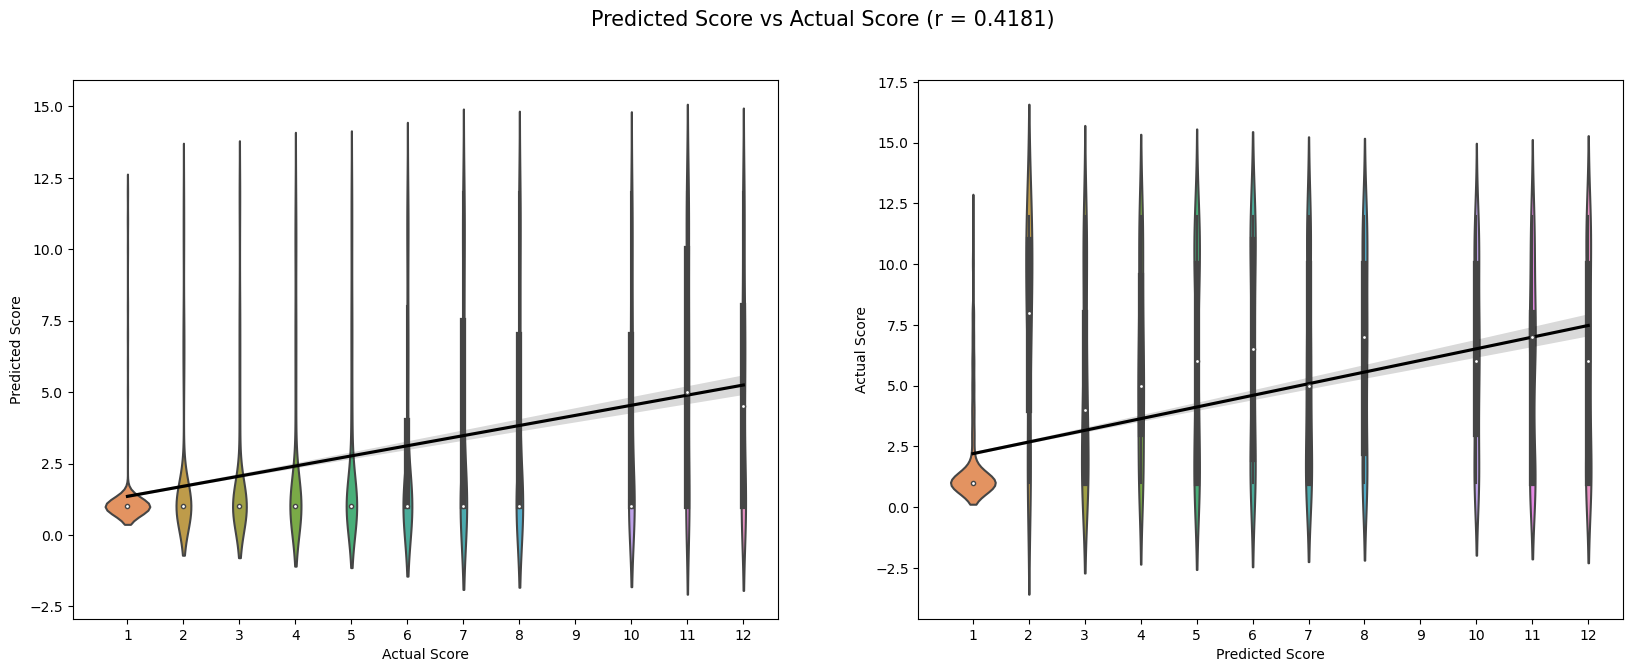

In [43]:
violins(predictions_final)

11


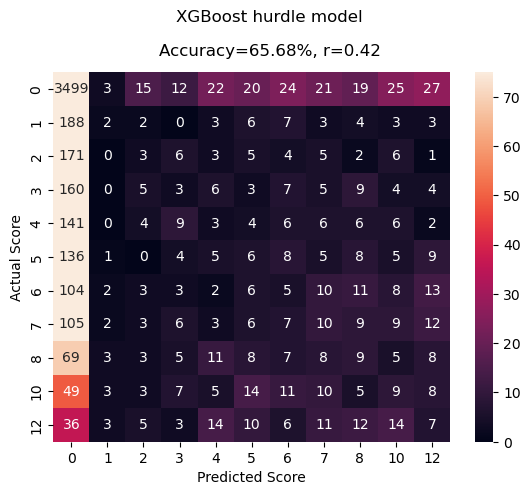

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import spearmanr

# confusion matrix for hurdle model

# evaluate predictions
accuracy = accuracy_score(predictions_final['predictions'], predictions_final['actual'])

cm = confusion_matrix(y_true=predictions_final['actual'], y_pred=predictions_final['predictions'])
plot = sns.heatmap(cm, annot=True, fmt='g', vmin=0, vmax=75)

print(len(cm[[0]][0]))

if(len(cm[[0]][0]) == 11) : 
# change the tick labels
    plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
else: 
    plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
    plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

# spearman correlation
corr, p = spearmanr(predictions_final['actual'], predictions_final['predictions'])

plot.text(x=6, y=-1.5, s= "XGBoost hurdle model", fontsize=12, ha="center")
plot.text(x=6, y=-0.5, s= "Accuracy=%.2f%%, r=%.2f"% (accuracy * 100.0, corr), fontsize=12, ha="center")
plot.set_ylabel('Actual Score')
plot.set_xlabel('Predicted Score')

plt.show()